In [18]:
import re
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

In [2]:
import pandas as pd

# Crawl stock price

## Selenium

In [19]:
# IBM
url = 'https://www.investing.com/equities/ibm-historical-data'

In [20]:
browser = webdriver.Firefox(executable_path='geckodriver.exe')

In [3]:
browser = webdriver.Chrome(executable_path='chromedriver.exe')
browser.maximize_window()

In [21]:
browser.get(url)

### Close popup

In [7]:
browser.find_element_by_class_name('popupCloseIcon.largeBannerCloser').click()

### Click the calendar

In [22]:
browser.find_element_by_id('widgetFieldDateRange').click()

### Find and input start date

In [23]:
startDate = browser.find_element_by_id('startDate')
startDate.clear()
startDate.send_keys('02/15/2001')
browser.find_element_by_id('applyBtn').send_keys(Keys.ENTER)

### Look up value

In [39]:
page_source = browser.page_source

# Find the real volume number
# Eg: <td data-real-value="114876432">114.88M</td>
# we need to take 114876432 from the source code
volume = re.findall(r'(data-real-value=")(\d+)(">\d+.\d+[BM])', page_source)
len(volume)

5000

In [40]:
str_xpath = '/html/body/div[5]/section/div[9]/table[1]/tbody/tr[{}]/td[{}]'

In [41]:
date = []
close = []
Open = []
high = []
low = []
vol = []
change =[]
index = [1, 2, 3, 4, 5, 7]

In [42]:
%%time
for i in range(1, 5000+1):
    vol.append(volume[i - 1][1])
    for j in index:
        xpath = str_xpath.format(i, j)
        real_value = browser.find_element_by_xpath(xpath)
        if j == 1:
            date.append(real_value.text)
        if j == 2:
            close.append(real_value.text)
        if j == 3:
            Open.append(real_value.text)
        if j == 4:
            high.append(real_value.text)
        if j == 5:
            low.append(real_value.text)
        if j == 7:
            change.append(real_value.text.strip('%'))

Wall time: 7min 46s


In [67]:
browser.quit()

In [43]:
len(date)

5000

In [44]:
len(close)

5000

In [45]:
len(Open)

5000

In [46]:
len(high)

5000

In [47]:
len(low)

5000

## Save dataframe

In [49]:
stock_price = pd.DataFrame({
    'Date': date, 
    'Close': close, 
    'Open': Open, 
    'High': high, 
    'Low': low,
    'Vol': vol,
    'Change_%': change
    })
stock_price

,Date,Close,Open,High,Low,Vol,Change_%
0,"Dec 30, 2020",124.34,123.74,124.82,123.63,3380494,0.44
1,"Dec 29, 2020",123.80,125.25,125.48,123.25,3487007,-0.82
2,"Dec 28, 2020",124.82,125.12,126.57,124.46,3615222,0.10
3,"Dec 24, 2020",124.69,125.00,125.10,124.21,1761122,0.64
4,"Dec 23, 2020",123.90,123.93,125.16,123.89,2693889,0.23
...,...,...,...,...,...,...,...
4995,"Feb 22, 2001",108.90,106.50,110.90,103.38,11709500,1.29
4996,"Feb 21, 2001",107.51,109.55,111.50,107.29,9158200,-3.58
4997,"Feb 20, 2001",111.50,114.55,115.60,110.78,6748300,-3.04
4998,"Feb 16, 2001",115.00,114.55,115.75,113.94,7073000,-1.52


In [50]:
stock_price.to_csv('stock_price.csv', index=False)

In [133]:
df = pd.read_csv('stock_price.csv', index_col=False)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      5000 non-null   object 
 1   Close     5000 non-null   float64
 2   Open      5000 non-null   float64
 3   High      5000 non-null   float64
 4   Low       5000 non-null   float64
 5   Vol       5000 non-null   int64  
 6   Change_%  5000 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 273.6+ KB


In [53]:
df.describe()

,Close,Open,High,Low,Vol,Change_%
count,5000.000000,5000.000000,5000.000000,5000.00000,5.000000e+03,5000.000000
mean,130.356260,130.297874,131.417356,129.26139,6.016475e+06,0.013694
std,38.247535,38.240502,38.330706,38.15226,3.290451e+06,1.558338
min,55.070000,54.650000,56.700000,54.01000,1.193025e+06,-12.850000
25%,94.530000,94.500000,95.347500,93.62000,3.797874e+06,-0.700000
50%,126.950000,126.825000,127.825000,125.83500,5.180760e+06,0.020000
75%,159.727500,159.720000,160.870000,158.64750,7.251085e+06,0.740000
max,215.800000,215.380000,215.900000,214.30000,4.121260e+07,11.510000


# Stock Indicators

## Trend Indicators 

### SMA
Simple moving average  
http://www.fmlabs.com/reference/default.htm?url=SimpleMA.htm  
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html

In [134]:
def SMA(df, time_period):
    indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=time_period)
    sma = df['Close'].rolling(window=indexer, min_periods=time_period).mean()
    df['SMA_' + str(time_period)] = sma
    return df

In [135]:
df = SMA(df, 20)
df

,Date,Close,Open,High,Low,Vol,Change_%,SMA_20
0,"Dec 30, 2020",124.34,123.74,124.82,123.63,3380494,0.44,124.8410
1,"Dec 29, 2020",123.80,125.25,125.48,123.25,3487007,-0.82,124.7820
2,"Dec 28, 2020",124.82,125.12,126.57,124.46,3615222,0.10,124.7680
3,"Dec 24, 2020",124.69,125.00,125.10,124.21,1761122,0.64,124.7445
4,"Dec 23, 2020",123.90,123.93,125.16,123.89,2693889,0.23,124.7200
...,...,...,...,...,...,...,...,...
4995,"Feb 22, 2001",108.90,106.50,110.90,103.38,11709500,1.29,NaN
4996,"Feb 21, 2001",107.51,109.55,111.50,107.29,9158200,-3.58,NaN
4997,"Feb 20, 2001",111.50,114.55,115.60,110.78,6748300,-3.04,NaN
4998,"Feb 16, 2001",115.00,114.55,115.75,113.94,7073000,-1.52,NaN


### EMA
Exponential moving average  
https://www.fmlabs.com/reference/default.htm?url=ExpMA.htm  
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html

In [136]:
def exponential_moving_average(df, time_period):
    EMA = df['Close'].iloc[::-1].ewm(span=time_period, min_periods=time_period, adjust=False).mean()
    df['EMA_' + str(time_period)] = EMA.iloc[::-1]
    return df

In [137]:
df = exponential_moving_average(df, 20)
df

,Date,Close,Open,High,Low,Vol,Change_%,SMA_20,EMA_20
0,"Dec 30, 2020",124.34,123.74,124.82,123.63,3380494,0.44,124.8410,123.945514
1,"Dec 29, 2020",123.80,125.25,125.48,123.25,3487007,-0.82,124.7820,123.903989
2,"Dec 28, 2020",124.82,125.12,126.57,124.46,3615222,0.10,124.7680,123.914935
3,"Dec 24, 2020",124.69,125.00,125.10,124.21,1761122,0.64,124.7445,123.819665
4,"Dec 23, 2020",123.90,123.93,125.16,123.89,2693889,0.23,124.7200,123.728051
...,...,...,...,...,...,...,...,...,...
4995,"Feb 22, 2001",108.90,106.50,110.90,103.38,11709500,1.29,NaN,NaN
4996,"Feb 21, 2001",107.51,109.55,111.50,107.29,9158200,-3.58,NaN,NaN
4997,"Feb 20, 2001",111.50,114.55,115.60,110.78,6748300,-3.04,NaN,NaN
4998,"Feb 16, 2001",115.00,114.55,115.75,113.94,7073000,-1.52,NaN,NaN


## Mean Reversion Indicators

### Bollinger Bands
https://www.fmlabs.com/reference/default.htm?url=Bollinger.htm  
https://quant.stackexchange.com/a/31905   

In [138]:
def bollinger_bands(df, time_period=20, n_std=2):
    indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=time_period)
    rolling_mean = df['Close'].rolling(window=indexer, min_periods=time_period).mean()
    rolling_std  = df['Close'].rolling(window=indexer, min_periods=time_period).std()
    upper_band = rolling_mean + (rolling_std*n_std)
    lower_band = rolling_mean - (rolling_std*n_std)
    df['BB_upper_' + str(time_period)] = upper_band
    df['BB_lower_' + str(time_period)] = lower_band
    return df

In [139]:
df = bollinger_bands(df, 20, 2)
df

,Date,Close,Open,High,Low,Vol,Change_%,SMA_20,EMA_20,BB_upper_20,BB_lower_20
0,"Dec 30, 2020",124.34,123.74,124.82,123.63,3380494,0.44,124.8410,123.945514,127.033580,122.648420
1,"Dec 29, 2020",123.80,125.25,125.48,123.25,3487007,-0.82,124.7820,123.903989,127.091720,122.472280
2,"Dec 28, 2020",124.82,125.12,126.57,124.46,3615222,0.10,124.7680,123.914935,127.106003,122.429997
3,"Dec 24, 2020",124.69,125.00,125.10,124.21,1761122,0.64,124.7445,123.819665,127.089739,122.399261
4,"Dec 23, 2020",123.90,123.93,125.16,123.89,2693889,0.23,124.7200,123.728051,127.077840,122.362160
...,...,...,...,...,...,...,...,...,...,...,...
4995,"Feb 22, 2001",108.90,106.50,110.90,103.38,11709500,1.29,NaN,NaN,NaN,NaN
4996,"Feb 21, 2001",107.51,109.55,111.50,107.29,9158200,-3.58,NaN,NaN,NaN,NaN
4997,"Feb 20, 2001",111.50,114.55,115.60,110.78,6748300,-3.04,NaN,NaN,NaN,NaN
4998,"Feb 16, 2001",115.00,114.55,115.75,113.94,7073000,-1.52,NaN,NaN,NaN,NaN


## Volume Indicators

### OBV
https://www.fmlabs.com/reference/default.htm?url=OBV.htm  
https://randerson112358.medium.com/stock-trading-strategy-using-on-balance-volume-obv-python-77a7c719cdac

In [140]:
def obv(df):
    OBV = [0]
    for i in range(1, len(df.Close)):
        # If the closing price is above the prior close price 
        if df.Close[i] > df.Close[i-1]:
            #then: Current OBV = Previous OBV + Current Volume
            OBV.append(OBV[-1] + df.Vol[i])
        elif df.Close[i] < df.Close[i-1]:
            OBV.append(OBV[-1] - df.Vol[i])
        else:
            OBV.append(OBV[-1])
    OBV.pop(0)
    OBV.append(None)
    df['OBV'] = OBV
    return df

In [141]:
df = obv(df)
df

,Date,Close,Open,High,Low,Vol,Change_%,SMA_20,EMA_20,BB_upper_20,BB_lower_20,OBV
0,"Dec 30, 2020",124.34,123.74,124.82,123.63,3380494,0.44,124.8410,123.945514,127.033580,122.648420,-3487007.0
1,"Dec 29, 2020",123.80,125.25,125.48,123.25,3487007,-0.82,124.7820,123.903989,127.091720,122.472280,128215.0
2,"Dec 28, 2020",124.82,125.12,126.57,124.46,3615222,0.10,124.7680,123.914935,127.106003,122.429997,-1632907.0
3,"Dec 24, 2020",124.69,125.00,125.10,124.21,1761122,0.64,124.7445,123.819665,127.089739,122.399261,-4326796.0
4,"Dec 23, 2020",123.90,123.93,125.16,123.89,2693889,0.23,124.7200,123.728051,127.077840,122.362160,-8664553.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,"Feb 22, 2001",108.90,106.50,110.90,103.38,11709500,1.29,NaN,NaN,NaN,NaN,-514875896.0
4996,"Feb 21, 2001",107.51,109.55,111.50,107.29,9158200,-3.58,NaN,NaN,NaN,NaN,-508127596.0
4997,"Feb 20, 2001",111.50,114.55,115.60,110.78,6748300,-3.04,NaN,NaN,NaN,NaN,-501054596.0
4998,"Feb 16, 2001",115.00,114.55,115.75,113.94,7073000,-1.52,NaN,NaN,NaN,NaN,-492955896.0


## Momentum Indicators

### MACD
Moving Average Convergence Divergence  
https://www.fmlabs.com/reference/default.htm?url=MACD.htm  
https://github.com/Crypto-toolbox/pandas-technical-indicators/blob/master/technical_indicators.py#L219

In [142]:
def macd(df, n_fast, n_slow):
    """Calculate MACD, MACD Signal and MACD difference
    :param df: pandas.DataFrame
    :param n_fast: 
    :param n_slow: 
    :return: pandas.DataFrame
    """
    EMAfast = df['Close'].iloc[::-1].ewm(span=n_fast, min_periods=n_fast, adjust=False).mean().iloc[::-1]
    EMAslow = df['Close'].iloc[::-1].ewm(span=n_slow, min_periods=n_slow, adjust=False).mean().iloc[::-1]
    MACD = EMAfast - EMAslow
    MACDsign = MACD.iloc[::-1].ewm(span=9, min_periods=9, adjust=False).mean().iloc[::-1]
    MACDdiff = MACD - MACDsign
    df['MACD_' + str(n_fast) + '_' + str(n_slow)] = MACD
    df['MACDsign_' + str(n_fast) + '_' + str(n_slow)] = MACDsign
    df['MACDdiff_' + str(n_fast) + '_' + str(n_slow)] = MACDdiff
    return df

In [143]:
df = macd(df, 12, 26)
df

,Date,Close,Open,High,Low,Vol,Change_%,SMA_20,EMA_20,BB_upper_20,BB_lower_20,OBV,MACD_12_26,MACDsign_12_26,MACDdiff_12_26
0,"Dec 30, 2020",124.34,123.74,124.82,123.63,3380494,0.44,124.8410,123.945514,127.033580,122.648420,-3487007.0,0.865134,1.227020,-0.361885
1,"Dec 29, 2020",123.80,125.25,125.48,123.25,3487007,-0.82,124.7820,123.903989,127.091720,122.472280,128215.0,0.937666,1.317491,-0.379825
2,"Dec 28, 2020",124.82,125.12,126.57,124.46,3615222,0.10,124.7680,123.914935,127.106003,122.429997,-1632907.0,1.071586,1.412447,-0.340861
3,"Dec 24, 2020",124.69,125.00,125.10,124.21,1761122,0.64,124.7445,123.819665,127.089739,122.399261,-4326796.0,1.123076,1.497662,-0.374587
4,"Dec 23, 2020",123.90,123.93,125.16,123.89,2693889,0.23,124.7200,123.728051,127.077840,122.362160,-8664553.0,1.185696,1.591309,-0.405613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,"Feb 22, 2001",108.90,106.50,110.90,103.38,11709500,1.29,NaN,NaN,NaN,NaN,-514875896.0,NaN,NaN,NaN
4996,"Feb 21, 2001",107.51,109.55,111.50,107.29,9158200,-3.58,NaN,NaN,NaN,NaN,-508127596.0,NaN,NaN,NaN
4997,"Feb 20, 2001",111.50,114.55,115.60,110.78,6748300,-3.04,NaN,NaN,NaN,NaN,-501054596.0,NaN,NaN,NaN
4998,"Feb 16, 2001",115.00,114.55,115.75,113.94,7073000,-1.52,NaN,NaN,NaN,NaN,-492955896.0,NaN,NaN,NaN


## Relative Strength Indicators

### RSI
Relative Strength Index  
https://www.fmlabs.com/reference/default.htm?url=RSI.htm  
https://tcoil.info/compute-rsi-for-stocks-with-python-relative-strength-index/

In [144]:
def RSI(df, time_period=14):
    diff = df['Close'].diff(1)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=time_window-1 so we get decay alpha=1/time_window
    up_chg_avg   = up_chg.iloc[::-1].ewm(com=time_period-1, min_periods=time_period, adjust=False).mean().iloc[::-1]
    down_chg_avg = down_chg.iloc[::-1].ewm(com=time_period-1, min_periods=time_period, adjust=False).mean().iloc[::-1]
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    
    df['RSI_' + str(time_period)] = rsi
    return df

In [145]:
df = RSI(df, 14)
df

,Date,Close,Open,High,Low,Vol,Change_%,SMA_20,EMA_20,BB_upper_20,BB_lower_20,OBV,MACD_12_26,MACDsign_12_26,MACDdiff_12_26,RSI_14
0,"Dec 30, 2020",124.34,123.74,124.82,123.63,3380494,0.44,124.8410,123.945514,127.033580,122.648420,-3487007.0,0.865134,1.227020,-0.361885,46.736086
1,"Dec 29, 2020",123.80,125.25,125.48,123.25,3487007,-0.82,124.7820,123.903989,127.091720,122.472280,128215.0,0.937666,1.317491,-0.379825,46.736086
2,"Dec 28, 2020",124.82,125.12,126.57,124.46,3615222,0.10,124.7680,123.914935,127.106003,122.429997,-1632907.0,1.071586,1.412447,-0.340861,48.493620
3,"Dec 24, 2020",124.69,125.00,125.10,124.21,1761122,0.64,124.7445,123.819665,127.089739,122.399261,-4326796.0,1.123076,1.497662,-0.374587,44.856413
4,"Dec 23, 2020",123.90,123.93,125.16,123.89,2693889,0.23,124.7200,123.728051,127.077840,122.362160,-8664553.0,1.185696,1.591309,-0.405613,45.234450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,"Feb 22, 2001",108.90,106.50,110.90,103.38,11709500,1.29,NaN,NaN,NaN,NaN,-514875896.0,NaN,NaN,NaN,NaN
4996,"Feb 21, 2001",107.51,109.55,111.50,107.29,9158200,-3.58,NaN,NaN,NaN,NaN,-508127596.0,NaN,NaN,NaN,NaN
4997,"Feb 20, 2001",111.50,114.55,115.60,110.78,6748300,-3.04,NaN,NaN,NaN,NaN,-501054596.0,NaN,NaN,NaN,NaN
4998,"Feb 16, 2001",115.00,114.55,115.75,113.94,7073000,-1.52,NaN,NaN,NaN,NaN,-492955896.0,NaN,NaN,NaN,NaN


### Info

In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            5000 non-null   object 
 1   Close           5000 non-null   float64
 2   Open            5000 non-null   float64
 3   High            5000 non-null   float64
 4   Low             5000 non-null   float64
 5   Vol             5000 non-null   int64  
 6   Change_%        5000 non-null   float64
 7   SMA_20          4981 non-null   float64
 8   EMA_20          4981 non-null   float64
 9   BB_upper_20     4981 non-null   float64
 10  BB_lower_20     4981 non-null   float64
 11  OBV             4999 non-null   float64
 12  MACD_12_26      4975 non-null   float64
 13  MACDsign_12_26  4967 non-null   float64
 14  MACDdiff_12_26  4967 non-null   float64
 15  RSI_14          4987 non-null   float64
dtypes: float64(14), int64(1), object(1)
memory usage: 625.1+ KB


In [147]:
df.to_csv('stock_price_with_indicators_nan.csv', index=False)

### Drop nan rows

In [148]:
df = df.dropna()
df

,Date,Close,Open,High,Low,Vol,Change_%,SMA_20,EMA_20,BB_upper_20,BB_lower_20,OBV,MACD_12_26,MACDsign_12_26,MACDdiff_12_26,RSI_14
0,"Dec 30, 2020",124.34,123.74,124.82,123.63,3380494,0.44,124.8410,123.945514,127.033580,122.648420,-3487007.0,0.865134,1.227020,-0.361885,46.736086
1,"Dec 29, 2020",123.80,125.25,125.48,123.25,3487007,-0.82,124.7820,123.903989,127.091720,122.472280,128215.0,0.937666,1.317491,-0.379825,46.736086
2,"Dec 28, 2020",124.82,125.12,126.57,124.46,3615222,0.10,124.7680,123.914935,127.106003,122.429997,-1632907.0,1.071586,1.412447,-0.340861,48.493620
3,"Dec 24, 2020",124.69,125.00,125.10,124.21,1761122,0.64,124.7445,123.819665,127.089739,122.399261,-4326796.0,1.123076,1.497662,-0.374587,44.856413
4,"Dec 23, 2020",123.90,123.93,125.16,123.89,2693889,0.23,124.7200,123.728051,127.077840,122.362160,-8664553.0,1.185696,1.591309,-0.405613,45.234450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4962,"Apr 10, 2001",99.05,97.00,99.90,96.56,10501300,3.18,94.1000,96.501084,100.902176,87.297824,-458620396.0,-1.572502,-2.788255,1.215753,52.381700
4963,"Apr 09, 2001",96.00,98.50,98.74,93.80,9487700,-1.99,94.0670,96.232777,100.773798,87.360202,-445196196.0,-2.018154,-3.092193,1.074039,50.149056
4964,"Apr 06, 2001",97.95,98.00,100.00,96.40,13424200,-0.26,94.0415,96.257280,100.721176,87.361824,-432690096.0,-2.247067,-3.360703,1.113636,54.626714
4965,"Apr 05, 2001",98.21,95.80,100.00,95.51,12506100,6.75,94.1085,96.079099,100.977445,87.239555,-446205996.0,-2.705105,-3.639112,0.934007,52.086958


In [149]:
df.to_csv('stock_price_with_indicators.csv', index=False)

# Visualization

In [3]:
df = pd.read_csv('stock_price_with_indicators.csv', index_col=False)

In [123]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)

## Trend Indicators

Text(0, 0.5, 'Price (USD)')

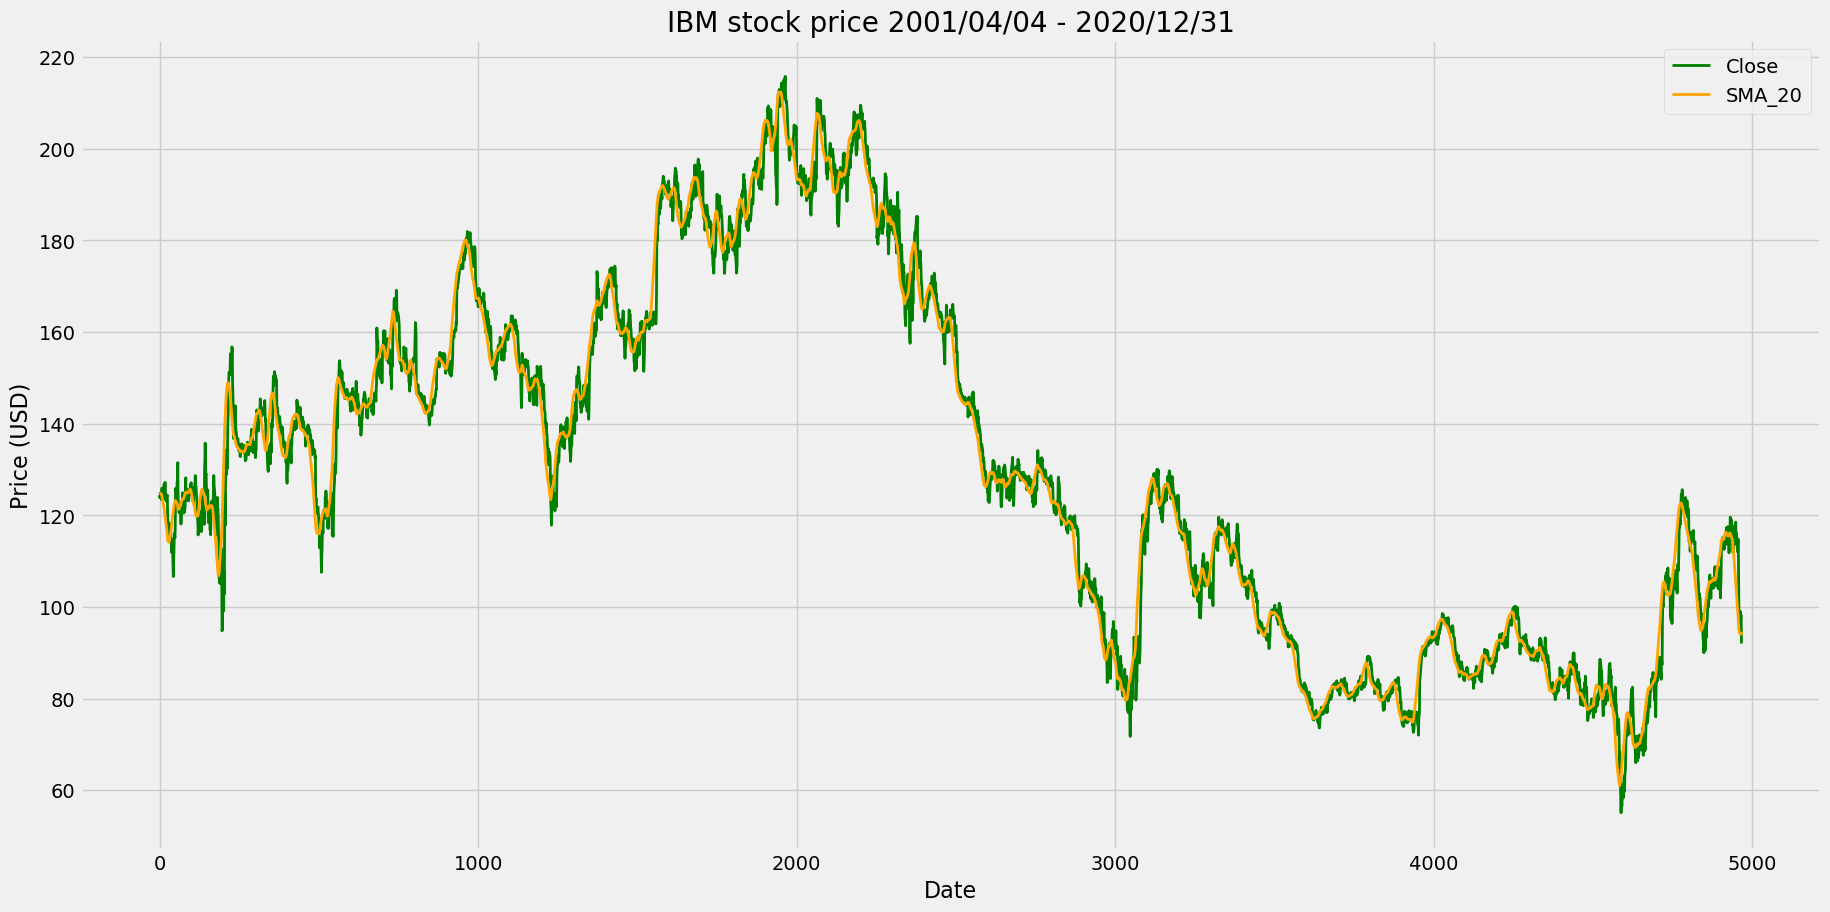

In [124]:
colors = ['green', 'orange']

df[['Close', 'SMA_20']].plot(color=colors, linewidth=2, figsize=(20,10))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['Close', 'SMA_20'], fontsize=14)

# title and labels
plt.title('IBM stock price 2001/04/04 - 2020/12/31', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price (USD)', fontsize=16)

Text(0, 0.5, 'Price (USD)')

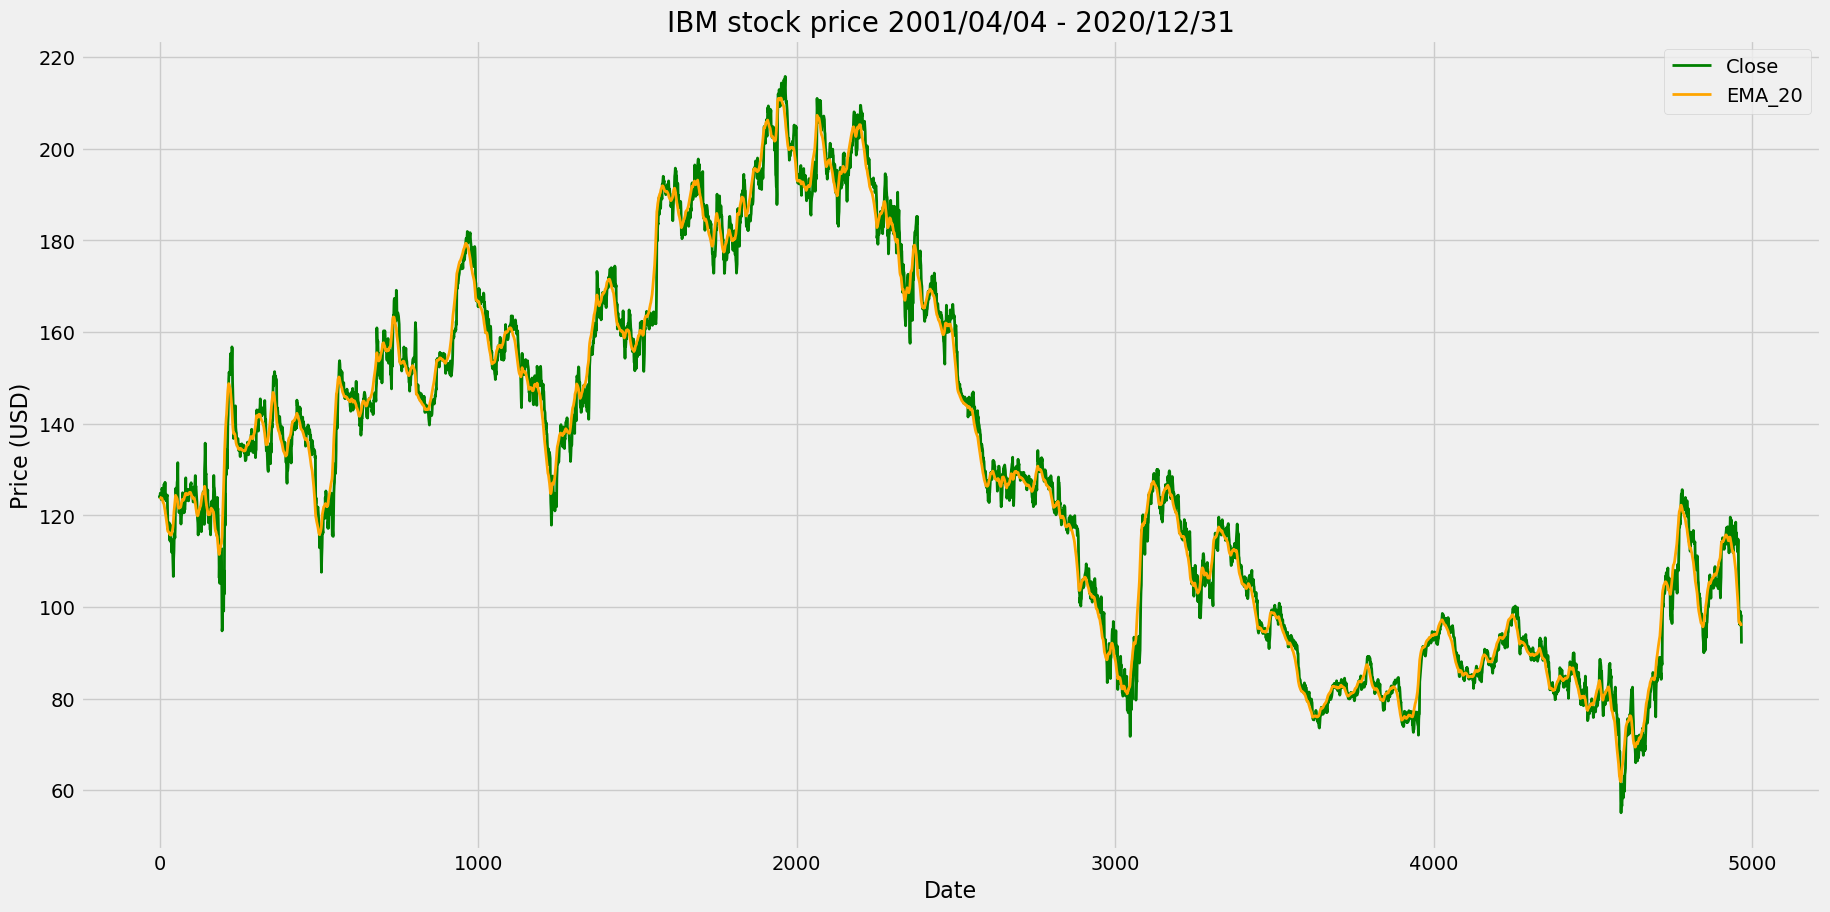

In [125]:
colors = ['green', 'orange']

df[['Close', 'EMA_20']].plot(color=colors, linewidth=2, figsize=(20,10))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['Close', 'EMA_20'], fontsize=14)

# title and labels
plt.title('IBM stock price 2001/04/04 - 2020/12/31', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price (USD)', fontsize=16)

Text(0, 0.5, 'Price (USD)')

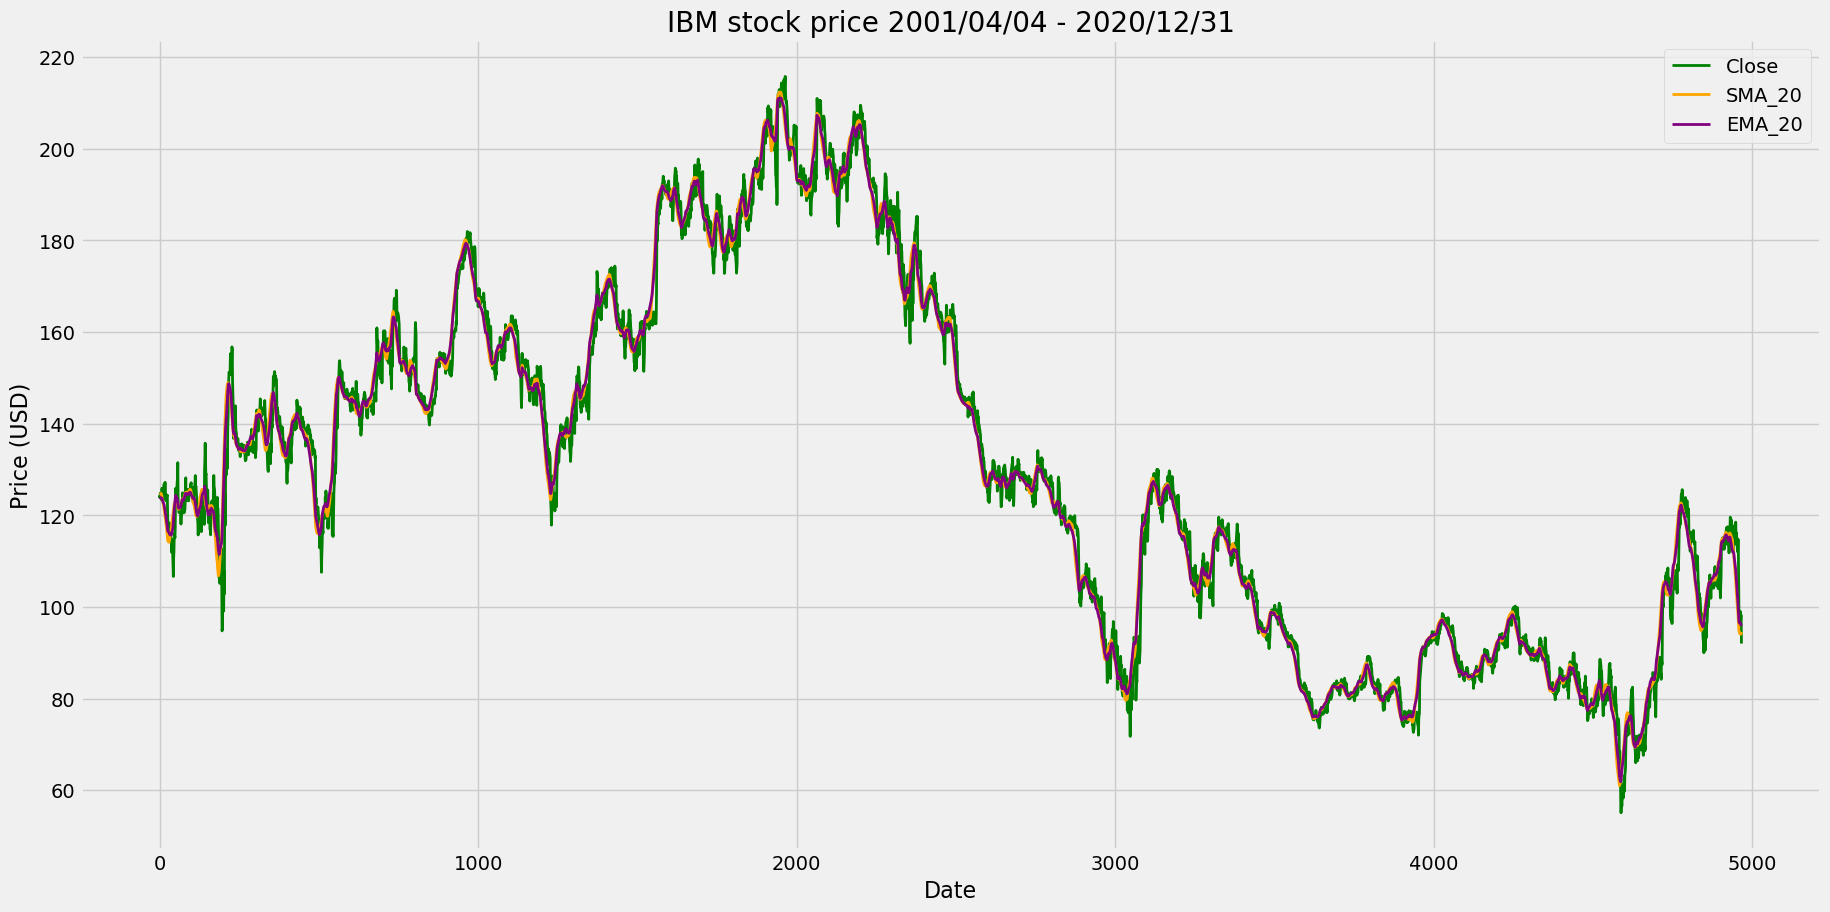

In [126]:
colors = ['green', 'orange', 'purple']

df[['Close', 'SMA_20', 'EMA_20']].plot(color=colors, linewidth=2, figsize=(20,10))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['Close', 'SMA_20', 'EMA_20'], fontsize=14)

# title and labels
plt.title('IBM stock price 2001/04/04 - 2020/12/31', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price (USD)', fontsize=16)

Text(0, 0.5, 'Price (USD)')

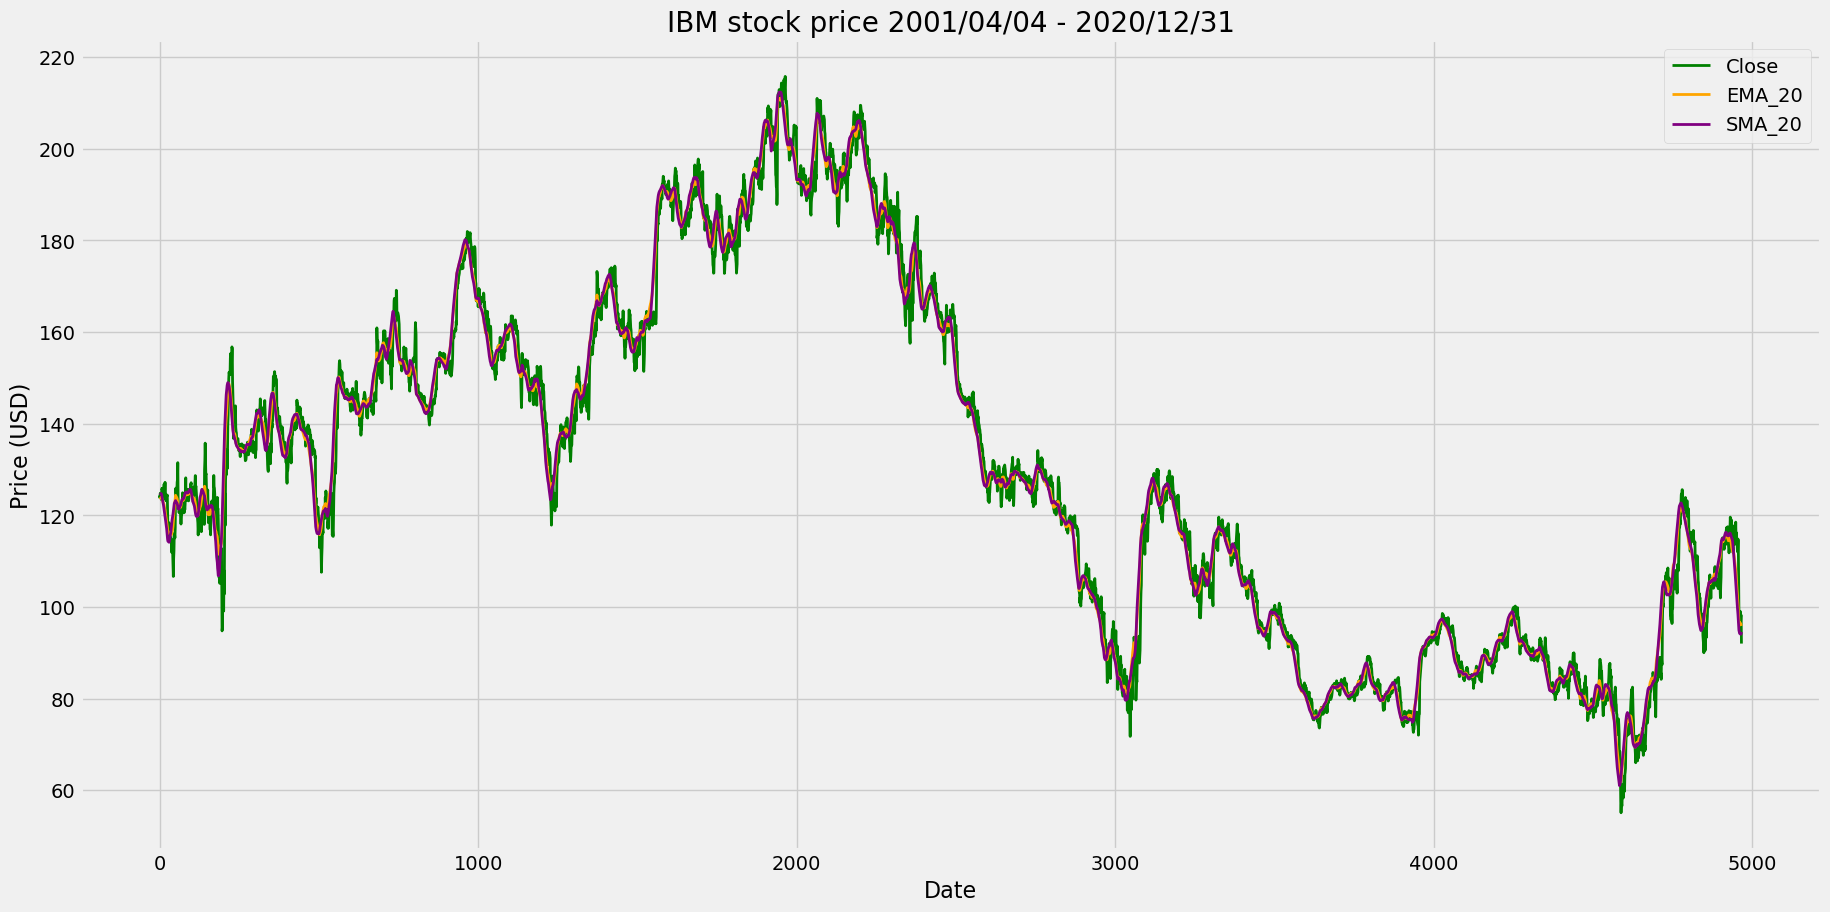

In [127]:
colors = ['green', 'orange', 'purple']

df[['Close', 'EMA_20', 'SMA_20']].plot(color=colors, linewidth=2, figsize=(20,10))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['Close', 'EMA_20', 'SMA_20'], fontsize=14)

# title and labels
plt.title('IBM stock price 2001/04/04 - 2020/12/31', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price (USD)', fontsize=16)

## Mean Reversion Indicators

Text(0, 0.5, 'Price (USD)')

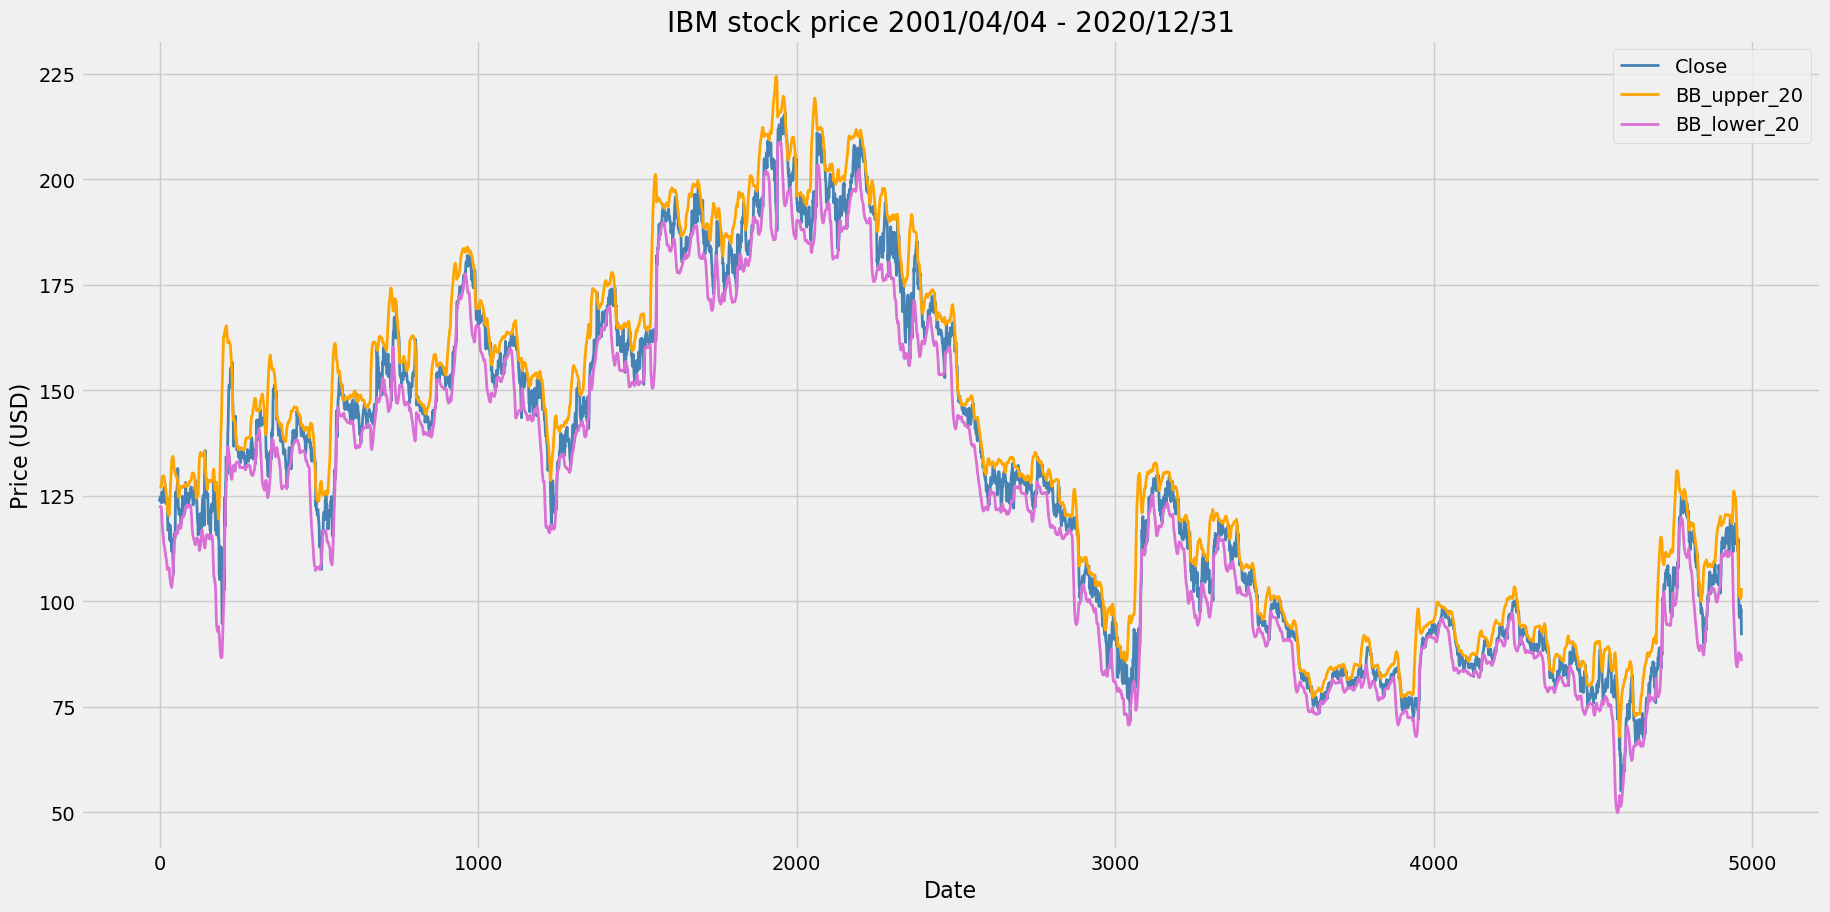

In [128]:
colors = ['steelblue', 'orange', 'orchid']

df[['Close', 'BB_upper_20', 'BB_lower_20']].plot(color=colors, linewidth=2, figsize=(20,10))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['Close', 'BB_upper_20', 'BB_lower_20'], fontsize=14)

# title and labels
plt.title('IBM stock price 2001/04/04 - 2020/12/31', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price (USD)', fontsize=16)

No handles with labels found to put in legend.


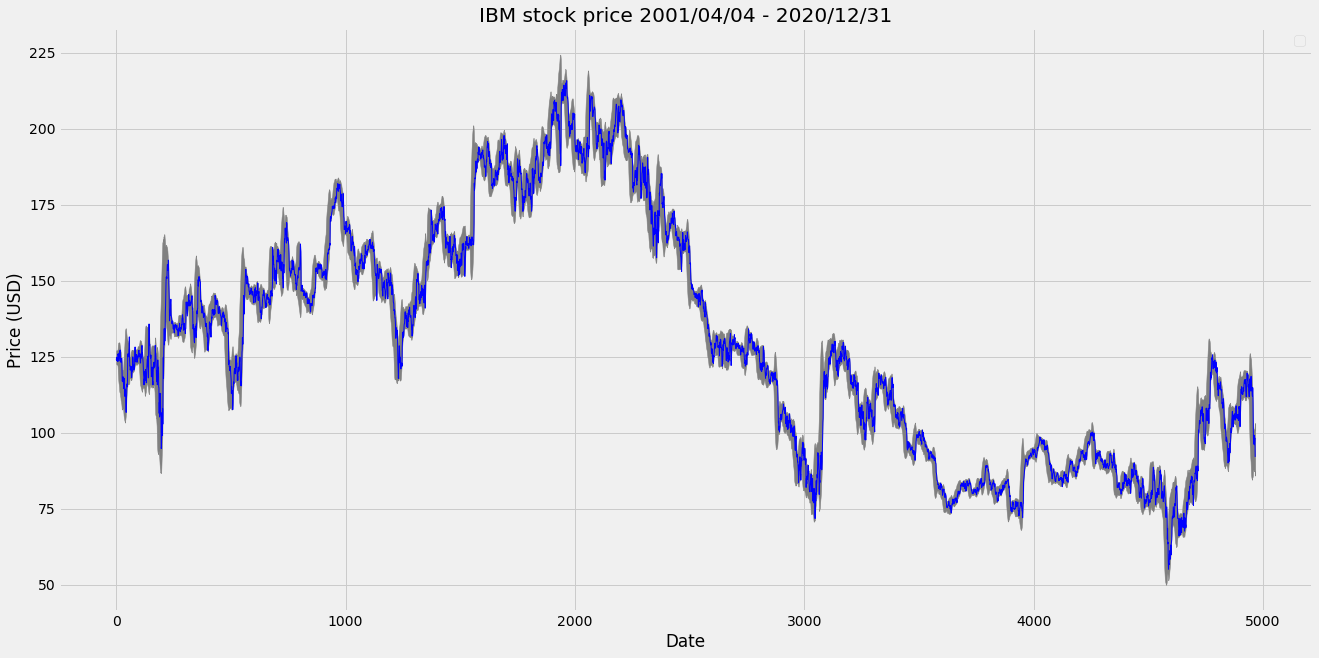

In [65]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

x_axis = df.index.get_level_values(0)

# Plot shaded 20 Day Bollinger Band for IBM
ax.fill_between(x_axis, df['BB_upper_20'], df['BB_lower_20'], color='grey')

# Plot Adjust Closing Price
ax.plot(x_axis, df['Close'], color='blue', linewidth=1)

# Set Title & Show the Image
ax.set_title('IBM stock price 2001/04/04 - 2020/12/31')
ax.set_xlabel('Date')
ax.set_ylabel('Price (USD)')
ax.legend()
plt.show();

## Volume Indicators

Text(0, 0.5, 'Price (USD)')

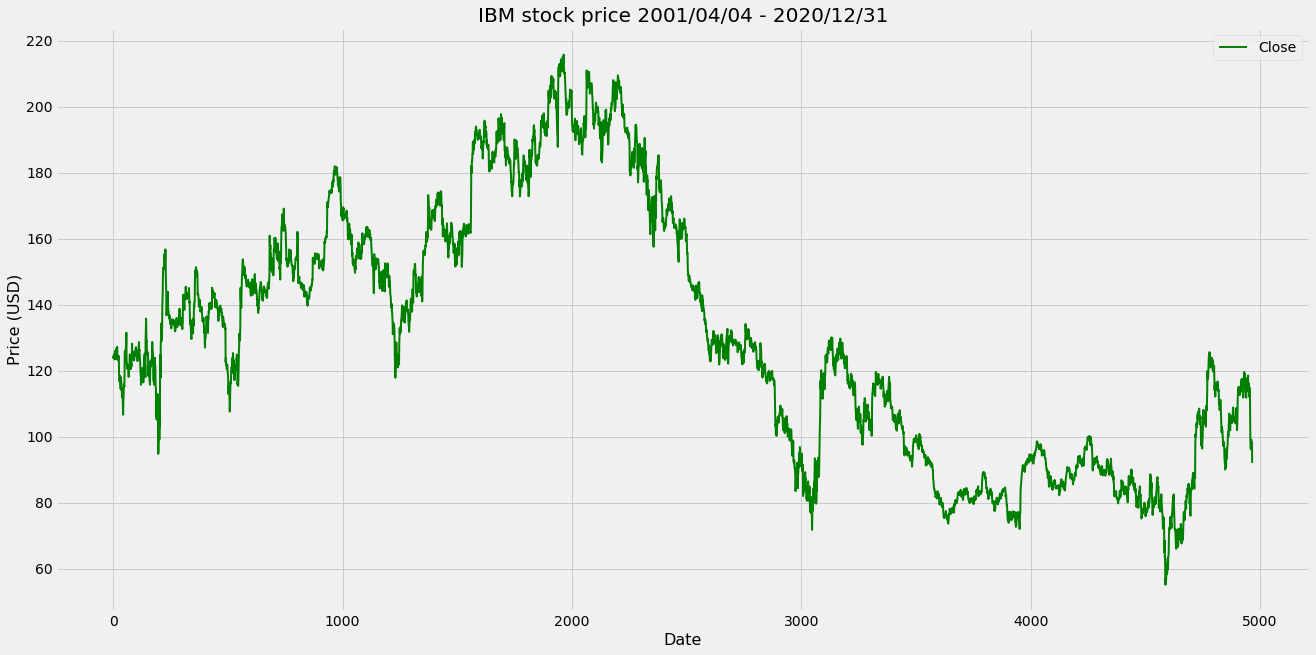

In [66]:
colors = ['green']

df[['Close']].plot(color=colors, linewidth=2, figsize=(20,10))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['Close'], fontsize=14)

# title and labels
plt.title('IBM stock price 2001/04/04 - 2020/12/31', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price (USD)', fontsize=16)

Text(0, 0.5, 'Price (USD)')

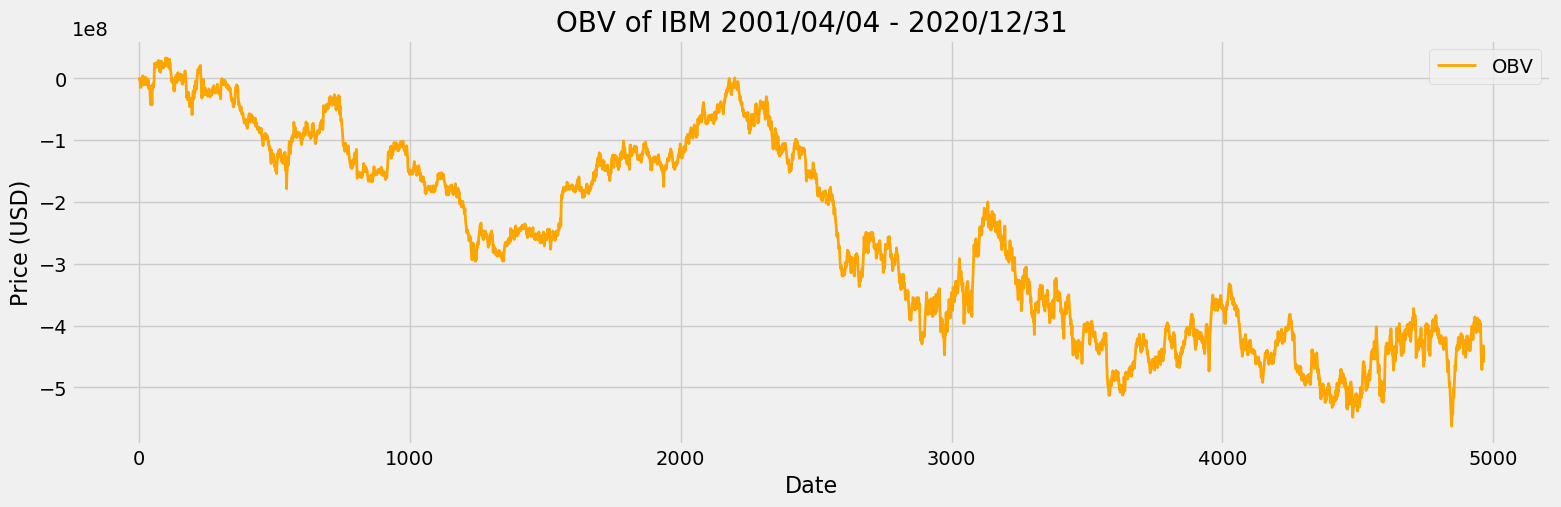

In [129]:
colors = ['orange']

df[['OBV']].plot(color=colors, linewidth=2, figsize=(17,5))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['OBV'], fontsize=14)

# title and labels
plt.title('OBV of IBM 2001/04/04 - 2020/12/31', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price (USD)', fontsize=16)

## Momentum Indicators

Text(0, 0.5, 'Price (USD)')

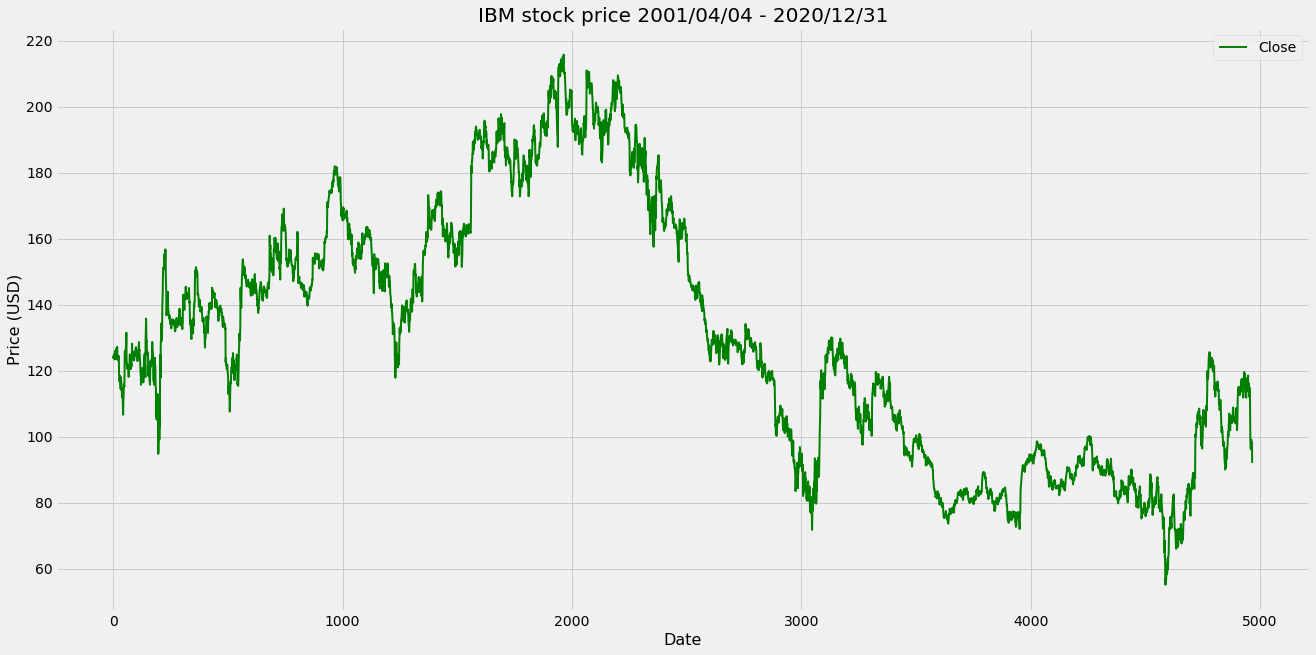

In [69]:
colors = ['green']

df[['Close']].plot(color=colors, linewidth=2, figsize=(20,10))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['Close'], fontsize=14)

# title and labels
plt.title('IBM stock price 2001/04/04 - 2020/12/31', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price (USD)', fontsize=16)

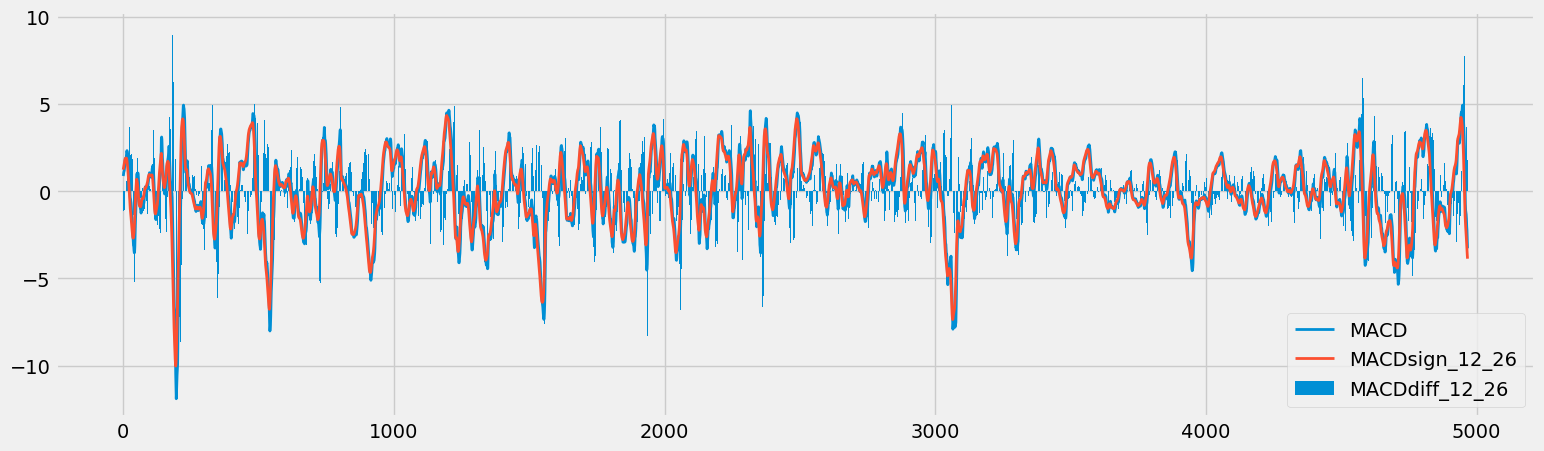

In [131]:
fig, ax = plt.subplots(figsize=(17,5))
ax.plot(df.index, df["MACD_12_26"], linewidth=2, label="MACD")
ax.bar(df.index, df["MACDdiff_12_26"] * 3, label="MACDdiff_12_26")
ax.plot(df.index, df["MACDsign_12_26"], linewidth=2, label="MACDsign_12_26")
ax.legend()

## Relative Strength Indicators

Text(0, 0.5, 'Price (USD)')

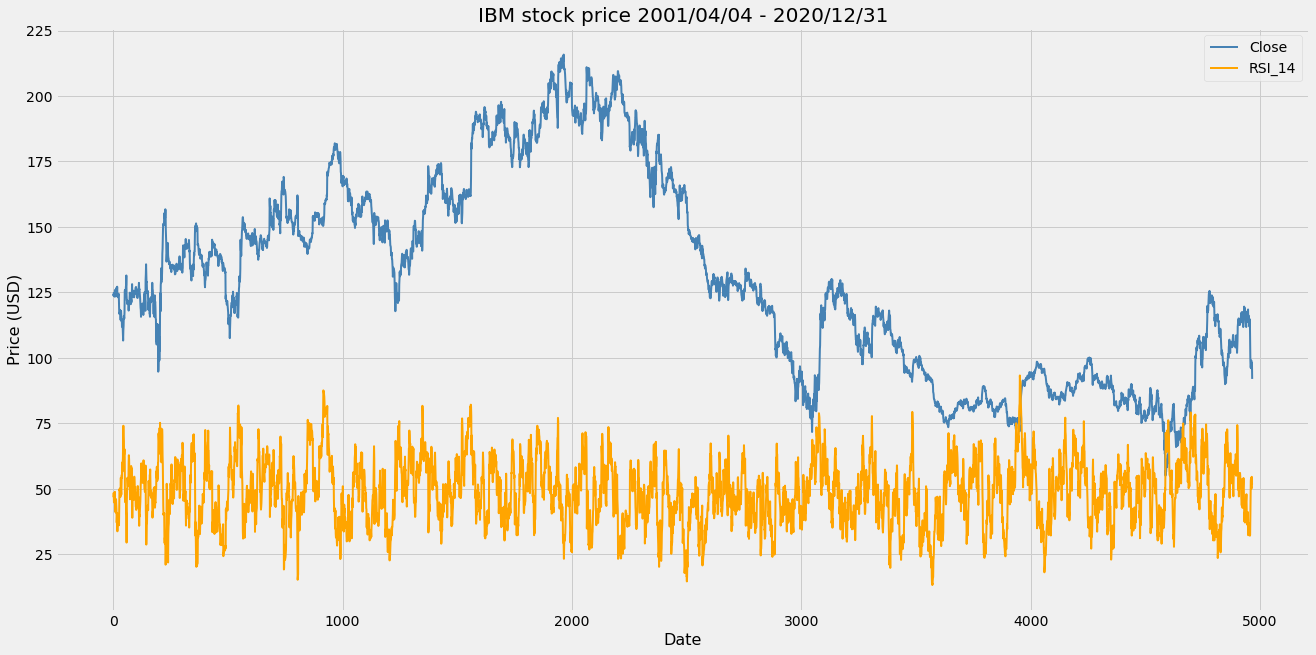

In [86]:
colors = ['steelblue', 'orange', 'orchid']

df[['Close', 'RSI_14']].plot(color=colors, linewidth=2, figsize=(20,10))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['Close', 'RSI_14'], fontsize=14)

# title and labels
plt.title('IBM stock price 2001/04/04 - 2020/12/31', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price (USD)', fontsize=16)

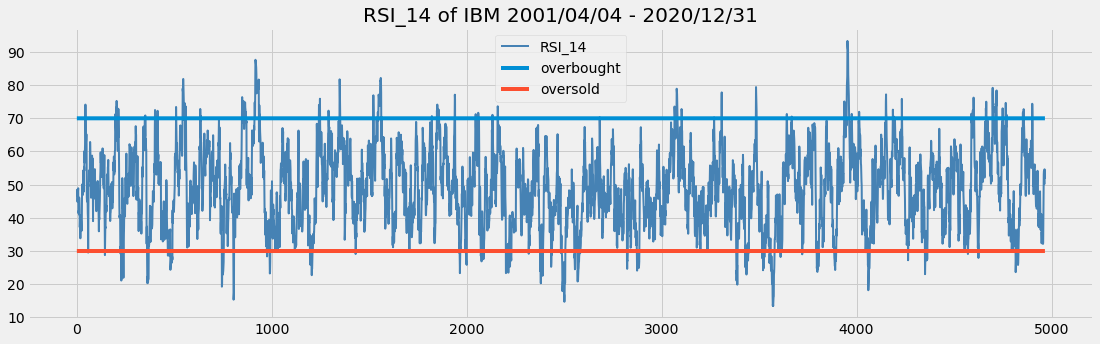

In [115]:
df['RSI_14'].plot(color=colors, linewidth=2, figsize=(17,5))
plt.plot(df.index, [70] * len(df.index), label="overbought")
plt.plot(df.index, [30] * len(df.index), label="oversold")
plt.title('RSI_14 of IBM 2001/04/04 - 2020/12/31', fontsize=20)
plt.legend()

Mỗi indicator đều cho ta các thông tin quan trọng.  
Để tìm ra indicator nào tốt cho mô hình thì chỉ có thể thử.